# Project: Investigate a Dataset (TMDb Movie Data)

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> **Tip**: In this section of the report, provide a brief introduction to the dataset you've selected for analysis. At the end of this section, describe the questions that you plan on exploring over the course of the report. Try to build your report around the analysis of at least one dependent variable and three independent variables.
>
> If you haven't yet selected and downloaded your data, make sure you do that first before coming back here. If you're not sure what questions to ask right now, then make sure you familiarize yourself with the variables and the dataset context for ideas of what to explore.


In [30]:
## import statements
import unicodecsv
from pprint import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## magics
%matplotlib inline

## initializations
sns.set_style('darkgrid')
tmdb_csv_file = 'tmdb-movies.csv'

<a id='wrangling'></a>
## Data Wrangling

> **Tip**: In this section of the report, you will load in the data, check for cleanliness, and then trim and clean your dataset for analysis. Make sure that you document your steps carefully and justify your cleaning decisions.

### General Properties

In [31]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.

## read csv file:
initial_df = pd.read_csv(tmdb_csv_file)
                         
## print first five rows in data:
initial_df.head()

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/15,2480,6.3,2015,1.012000e+08,2.716190e+08
3,140607,tt2488496,11.173104,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,...,Thirty years after defeating the Galactic Empi...,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/15,5292,7.5,2015,1.839999e+08,1.902723e+09
4,168259,tt2820852,9.335014,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,http://www.furious7.com/,James Wan,Vengeance Hits Home,...,Deckard Shaw seeks revenge against Dominic Tor...,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,4/1/15,2947,7.3,2015,1.747999e+08,1.385749e+09


In [32]:
# number of rows (movies):
len(initial_df)

10866

In [33]:
## range of years from which movies are included:

release_years = initial_df['release_year']
print(int(release_years.min()),'-',int(release_years.max()))

1960 - 2015


In [56]:
## most grossing movie:

max_revenue_idx = initial_df['revenue_adj'].idxmax()
name = initial_df.loc[max_revenue_idx, 'original_title']
revenue = initial_df.loc[max_revenue_idx, 'revenue_adj']
year = initial_df.loc[max_revenue_idx, 'release_year']
budget = initial_df.loc[max_revenue_idx, 'budget_adj']

print('{}, {}'.format(name, year))
print('Revenue:', revenue, 'USD')
print('Budget', budget, 'USD')

Avatar, 2009
Revenue: 2827123750.41189 USD
Budget 240886902.887613 USD


### Budgets

In [34]:
## budget statistics (adjusted):

budgets_adj = initial_df['budget_adj']
budgets_adj.describe()

count    1.086600e+04
mean     1.755104e+07
std      3.430616e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.085325e+07
max      4.250000e+08
Name: budget_adj, dtype: float64

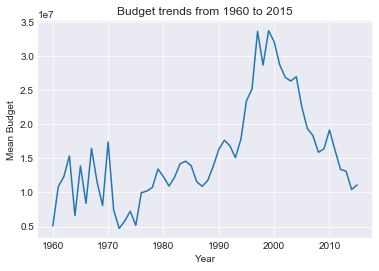

In [35]:
## year-wise trends in mean budgets:

budgets_grouped_by_year = initial_df.groupby('release_year', as_index=False)['budget_adj']
yearly_budget_means = budgets_grouped_by_year.mean()

plt.plot(yearly_budget_means['release_year'], yearly_budget_means['budget_adj'])
plt.xlabel('Year')
plt.ylabel('Mean Budget')
plt.title('Budget trends from 1960 to 2015')
plt.show()

### Revenues

In [36]:
## revenue statistics (adjusted):

revenues_adj = initial_df['revenue_adj']
revenues_adj.describe()

count    1.086600e+04
mean     5.136436e+07
std      1.446325e+08
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      3.369710e+07
max      2.827124e+09
Name: revenue_adj, dtype: float64

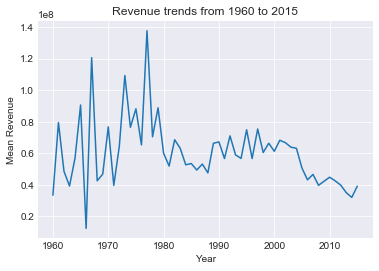

In [41]:
## year-wise trends in mean revenues:

revenues_grouped_by_year = initial_df.groupby('release_year', as_index=False)['revenue_adj']
yearly_revenue_means = revenues_grouped_by_year.mean()

plt.plot(yearly_revenue_means['release_year'], yearly_revenue_means['revenue_adj'])
plt.xlabel('Year')
plt.ylabel('Mean Revenue')
plt.title('Revenue trends from 1960 to 2015')
plt.show()

> **Tip**: You should _not_ perform too many operations in each cell. Create cells freely to explore your data. One option that you can take with this project is to do a lot of explorations in an initial notebook. These don't have to be organized, but make sure you use enough comments to understand the purpose of each code cell. Then, after you're done with your analysis, create a duplicate notebook where you will trim the excess and organize your steps so that you have a flowing, cohesive report.

> **Tip**: Make sure that you keep your reader informed on the steps that you are taking in your investigation. Follow every code cell, or every set of related code cells, with a markdown cell to describe to the reader what was found in the preceding cell(s). Try to make it so that the reader can then understand what they will be seeing in the following cell(s).

### Data Cleaning (Replace this with more specific notes!)

In [ ]:
# After discussing the structure of the data and any problems that need to be
#   cleaned, perform those cleaning steps in the second part of this section.


<a id='eda'></a>
## Exploratory Data Analysis

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. Compute statistics and create visualizations with the goal of addressing the research questions that you posed in the Introduction section. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables.

### Research Question 1 (Replace this header name!)

In [ ]:
# Use this, and more code cells, to explore your data. Don't forget to add
#   Markdown cells to document your observations and findings.


### Research Question 2  (Replace this header name!)

In [ ]:
# Continue to explore the data to address your additional research
#   questions. Add more headers as needed if you have more questions to
#   investigate.


<a id='conclusions'></a>
## Conclusions

> **Tip**: Finally, summarize your findings and the results that have been performed. Make sure that you are clear with regards to the limitations of your exploration. If you haven't done any statistical tests, do not imply any statistical conclusions. And make sure you avoid implying causation from correlation!

> **Tip**: Once you are satisfied with your work, you should save a copy of the report in HTML or PDF form via the **File** > **Download as** submenu. Before exporting your report, check over it to make sure that the flow of the report is complete. You should probably remove all of the "Tip" quotes like this one so that the presentation is as tidy as possible. Congratulations!